# News Mode

1. As of today, CBCNew and FoxNews are slightly positive, and other three are somehow negative
2. Among all news organizations, BBSWord is the most negative
4. There are significant number of neturls when all media

BTW:

- I could not find exact match for BBC, so I use BBCWord instead.
- For CBS, I pick CBSNews instead of CBS as CBS in general include not just news, but also entertainments etc.
- There is no twitter handle called FOX, so I pick FoxNews instead
- For nytimnes, I see the example use 'New York Times' and "NYT' but I stil to nytimes, as it is more consistent this way.

## Imports

In [1]:
# Core
from datetime import date
from operator import itemgetter
import json

# Numpy, Pandas and PyPlot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style(
    'darkgrid', 
    {
        'axes.facecolor': '0.9',
    }
)

# API
import tweepy
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Own
from twitter_config import *

## Gobals & Constants

In [2]:
PAGE_SIZE = 20
PAGES = 5
MEDIA_SOURCES = ['BBCWorld', 'CBSNews', 'CNN', 'FoxNews', 'nytimes']
SCORES = ['compound', 'neg', 'pos', 'neu']

COLORS = {
    'BBCWorld': 'lightskyblue',
    'CBSNews': 'green',
    'CNN': 'lightcoral',
    'FoxNews': 'blue',
    'nytimes': 'gold'
}

TODAY = date.today().strftime('%m/%d/%y')

_AUTH = tweepy.OAuthHandler(TWITTER_CONSUMER_KEY, TWITTER_CONSUMER_SECRET)
_AUTH.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_TOKEN_SECRET)

TWITTER_API = tweepy.API(_AUTH, parser=tweepy.parsers.JSONParser())
SENTIMENT_ANALYZER = SentimentIntensityAnalyzer()

## Gather Data
Use multil-index to better organize the data

In [3]:
df = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        [MEDIA_SOURCES, list(range(PAGE_SIZE * PAGES))],
        names=['Media Sources', 'Tweets Ago']
    ),
    columns=SCORES
)

for media_source in MEDIA_SOURCES:
    tweets_ago = 0
    for page in range(PAGES):
        for tweet in TWITTER_API.user_timeline(media_source, count=PAGE_SIZE, page=page):
            df.loc[(media_source, tweets_ago), SCORES] = itemgetter(*SCORES)(
                SENTIMENT_ANALYZER.polarity_scores(tweet['text']))
            tweets_ago += 1    
df.head()

compound    neg    pos    neu
Media Sources Tweets Ago                              
BBCWorld      0                 0      0      0      1
              1                 0      0      0      1
              2            0.6486      0  0.469  0.531
              3           -0.7845  0.496      0  0.504
              4           -0.1531  0.292  0.236  0.472

In [4]:
### Export to CSV

In [5]:
df.to_csv('NewsMode.csv')

### Sentiment Scater Plot

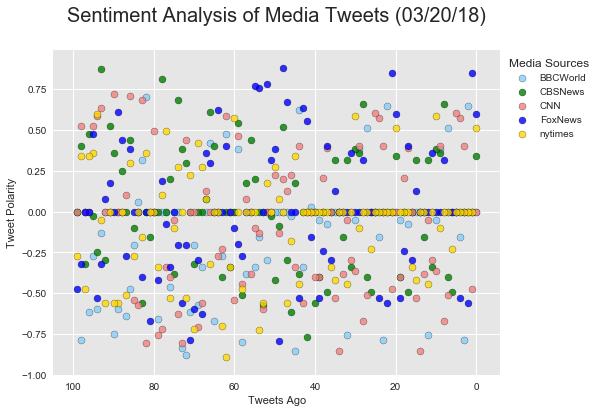

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

for media_source in MEDIA_SOURCES:
    df_media = df.loc[media_source]
    ax.scatter(
        x=df_media.index,
        y=df_media['compound'],
        c=COLORS[media_source],
        marker='o',
        alpha=0.8,
        edgecolor='black',
        label=media_source
    )

ax.legend(
    title='Media Sources',
    bbox_to_anchor=(1.22, 1)
)

plt.gca().invert_xaxis()
plt.title(f'Sentiment Analysis of Media Tweets ({TODAY})\n', fontsize=20)
plt.xlabel('Tweets Ago')
plt.ylabel('Tweet Polarity')
plt.savefig('NewsMode_scatter.png', bbox_inches='tight')
plt.show()

### Sentiment Overall

In [7]:
df_mean = pd.to_numeric(df['compound']).groupby('Media Sources').mean()
df_mean

Media Sources
BBCWorld   -0.114162
CBSNews     0.016635
CNN        -0.070667
FoxNews     0.016704
nytimes    -0.060800
Name: compound, dtype: float64

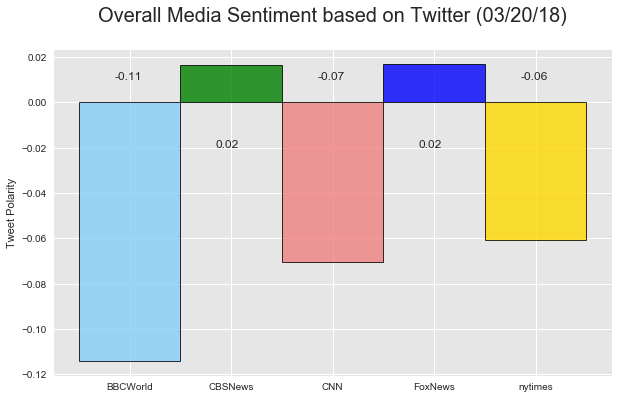

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(
    MEDIA_SOURCES,
    df_mean,
    align='edge',
    width=1,
    edgecolor='black',
    color=[COLORS[m] for m in MEDIA_SOURCES],
    linewidth=1,
    alpha=0.8,
)

plt.title(f'Overall Media Sentiment based on Twitter ({TODAY})\n',
          fontsize=20)
plt.ylabel('Tweet Polarity')
plt.xticks(np.arange(0.5, len(MEDIA_SOURCES)), rotation=0)

# Add labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + 0.35, 
            0.01 if height < 0 else -0.02, 
            '{:.2f}'.format(height))
   
plt.savefig('NewsMode_bar.png')
plt.show()